# Amazon Review Classification using BERT

In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
%load_ext tensorboard

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

<pre><font size=6>Preprocessing</font></pre>

In [5]:
reviews = pd.read_csv(r"Reviews.csv")
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
reviews = reviews[['Text','Score']]
reviews.shape

(568454, 2)

In [7]:
#get only 2 columns - Text, Score
#drop the NAN values
reviews = reviews.dropna(axis=0)
reviews.shape

(568454, 2)

In [8]:
reviews = reviews[reviews['Score'] != 3]
reviews['Score'] = [1 if i > 3 else 0 for i in reviews['Score']]
print(reviews.shape)
reviews['Score'].value_counts()

(525814, 2)


1    443777
0     82037
Name: Score, dtype: int64

In [10]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [11]:
#remove HTML from the Text column and save in the Text column only
import re
reviews['Text'] = [re.sub(r"(<.*?>)", '', i) for i in reviews['Text']]

In [12]:
reviews.head(5)

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [13]:
#split the data into train and test data(20%) with Stratify sampling,
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews.drop('Score',axis=1), reviews['Score'],
                                                    test_size=0.33, random_state=33,stratify=reviews['Score'])

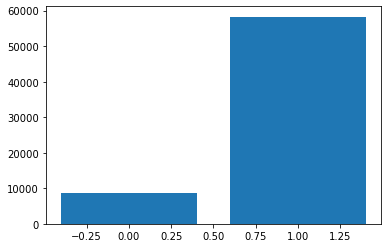

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(y_train.value_counts().index,y_train.value_counts().values)
plt.show()

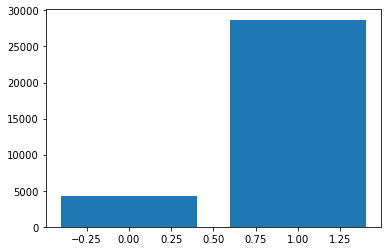

In [15]:
plt.bar(y_test.value_counts().index,y_test.value_counts().values)
plt.show()

In [16]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Creating BERT Model</font> 

In [17]:
tf.keras.backend.clear_session()

max_seq_length = 55

#this is input words
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [18]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [19]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Tokenization</font></pre>

In [20]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [21]:
import tokenization

In [23]:
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

In [26]:
X_train_tokens = np.array([np.array(tokenizer.tokenize(i)) for i in X_train.Text],dtype='object')
X_test_tokens = np.array([np.array(tokenizer.tokenize(i)) for i in X_test.Text],dtype='object')
print(X_train_tokens[0])

['lava' '##zza' 'coffee' 'is' 'the' 'best' 'coffee' 'ever' ',' 'we' 'love'
 'it' ',' 'every' 'pot' 'brew' '##s' 'up' 'so' 'smooth' 'even' 'when'
 'brew' '##ed' 'very' 'strong' '.']


In [27]:
X_train_tokens = np.array([np.array(['[CLS]',*(i[0:max_seq_length-2]),'[SEP]']) for i in X_train_tokens],dtype='object')
X_test_tokens = np.array([np.array(['[CLS]',*(i[0:max_seq_length-2]),'[SEP]']) for i in X_test_tokens],dtype='object')
print(X_train_tokens[0])

['[CLS]' 'lava' '##zza' 'coffee' 'is' 'the' 'best' 'coffee' 'ever' ','
 'we' 'love' 'it' ',' 'every' 'pot' 'brew' '##s' 'up' 'so' 'smooth' 'even'
 'when' 'brew' '##ed' 'very' 'strong' '.' '[SEP]']


In [28]:
np.concatenate((X_train_tokens[0], np.array(['[PAD]']*(max_seq_length - len(X_train_tokens[0])))), axis=None)

array(['[CLS]', 'lava', '##zza', 'coffee', 'is', 'the', 'best', 'coffee',
       'ever', ',', 'we', 'love', 'it', ',', 'every', 'pot', 'brew',
       '##s', 'up', 'so', 'smooth', 'even', 'when', 'brew', '##ed',
       'very', 'strong', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]'], dtype='<U6')

In [29]:
X_train_tokens[0]

array(['[CLS]', 'lava', '##zza', 'coffee', 'is', 'the', 'best', 'coffee',
       'ever', ',', 'we', 'love', 'it', ',', 'every', 'pot', 'brew',
       '##s', 'up', 'so', 'smooth', 'even', 'when', 'brew', '##ed',
       'very', 'strong', '.', '[SEP]'], dtype='<U6')

In [30]:
tr_tok = []
for l in X_train_tokens:
    if len(l) < max_seq_length:
        tr_tok.append(np.concatenate((l, np.array(['[PAD]']*(max_seq_length - len(l)))), axis=None))
    else:
        tr_tok.append(l)
te_tok = []
for l in X_test_tokens:
    if len(l) < max_seq_length:
        te_tok.append(np.concatenate((l, np.array(['[PAD]']*(max_seq_length - len(l)))), axis=None))
    else:
        te_tok.append(l)
X_train_tokens = np.array(tr_tok,dtype='object')
X_test_tokens = np.array(te_tok,dtype='object')
print(X_train_tokens[0])

['[CLS]' 'lava' '##zza' 'coffee' 'is' 'the' 'best' 'coffee' 'ever' ','
 'we' 'love' 'it' ',' 'every' 'pot' 'brew' '##s' 'up' 'so' 'smooth' 'even'
 'when' 'brew' '##ed' 'very' 'strong' '.' '[SEP]' '[PAD]' '[PAD]' '[PAD]'
 '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
 '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
 '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]']


In [31]:
X_train_mask = []
for s in X_train_tokens:
    X_train_mask.append([0 if i == '[PAD]' else 1 for i in s])
X_test_mask = []
for s in X_test_tokens:
    X_test_mask.append([0 if i == '[PAD]' else 1 for i in s])
    
X_train_mask = np.array(X_train_mask)
X_test_mask = np.array(X_test_mask)
print(X_train_mask[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [32]:
X_train_segment = np.array([np.array([0]*max_seq_length) for i in X_train_tokens],dtype='object')
X_test_segment = np.array([np.array([0]*max_seq_length) for i in X_test_tokens],dtype='object')
print(X_train_segment[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [33]:
X_train_tokens = np.array([np.array(tokenizer.convert_tokens_to_ids(i)) for i in X_train_tokens],dtype='object')
X_test_tokens = np.array([np.array(tokenizer.convert_tokens_to_ids(i)) for i in X_test_tokens],dtype='object')
print(X_train_tokens[0])

[101 13697 20715 4157 2003 1996 2190 4157 2412 1010 2057 2293 2009 1010
 2296 8962 24702 2015 2039 2061 5744 2130 2043 24702 2098 2200 2844 1012
 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [34]:
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [4]:
#max_seq_length = 55
#X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
#X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<pre><font size=6>Getting Embeddings from BERT Model</font>

In [37]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [38]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [39]:
X_train_pooled_output=bert_model.predict([X_train_tokens.astype('float32'),X_train_mask.astype('float32'),X_train_segment.astype('float32')])

In [40]:
X_test_pooled_output=bert_model.predict([X_test_tokens.astype('float32'),X_test_mask.astype('float32'),X_test_segment.astype('float32')])

In [41]:
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [5]:
#X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<pre><font size=6>Training a NN with 768 features</font>

In [43]:
##imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

def rocscore(y_true, y_pred):
    try:
        score = roc_auc_score(y_true, y_pred)
        rocscore.prev_score = score
    except:
        score = rocscore.prev_score
    return score
rocscore.prev_score = 0      

def auroc(y_true, y_pred):
    return tf.py_function(rocscore, (y_true, y_pred), tf.double)

In [44]:
inputs = layers.Input(shape=(X_train_pooled_output.shape[1],))

dense = layers.Dense(100,activation="elu",kernel_initializer='he_normal')(inputs)

dense2 = layers.Dense(75,activation="elu",kernel_initializer='he_normal')(dense)

dropout2 = layers.Dropout(0.3)(dense2)

dense3 = layers.Dense(64,activation="elu",kernel_initializer='he_normal')(dropout2)

bn =layers.BatchNormalization()(dense3)

dense4 = layers.Dense(8,activation="relu",kernel_initializer='he_normal')(bn)

classification_output = layers.Dense(1,activation="sigmoid")(dense4)

model1 = keras.Model(inputs=inputs, outputs=classification_output, name="Model1")

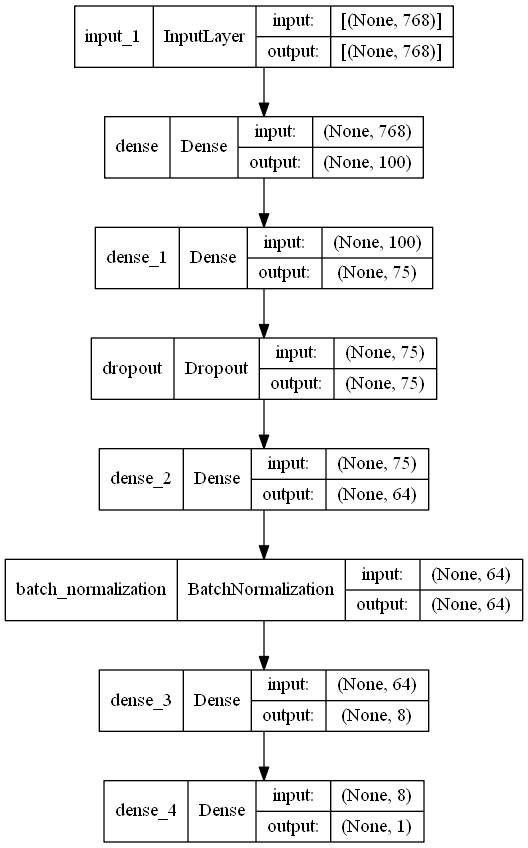

In [45]:
keras.utils.plot_model(model1, to_file='model1.png', show_shapes=True)

In [46]:
model1.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 100)               76900     
                                                                 
 dense_1 (Dense)             (None, 75)                7575      
                                                                 
 dropout (Dropout)           (None, 75)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4864      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                            

In [47]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [48]:
model1.compile(loss= "binary_crossentropy",
               optimizer=keras.optimizers.Adam(),
               metrics=[auroc])

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = 'my_best_model.epoch{epoch:02d}-auroc{val_auroc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_auroc',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [50]:
model1.fit(X_train_pooled_output,
           y_train,
           epochs=15,
           batch_size = 128,
           validation_data=(X_test_pooled_output, y_test),
           callbacks=[checkpoint,tensorboard_callback],
           verbose=1)

Epoch 1/15
523/524 [============================>.] - ETA: 0s - loss: 0.2702 - auroc: 0.8606
Epoch 00001: val_auroc improved from -inf to 0.94753, saving model to my_best_model.epoch01-auroc0.95.hdf5
524/524 [==============================] - 5s 8ms/step - loss: 0.2701 - auroc: 0.8607 - val_loss: 0.2265 - val_auroc: 0.9475
Epoch 2/15
519/524 [============================>.] - ETA: 0s - loss: 0.1901 - auroc: 0.9447
Epoch 00002: val_auroc improved from 0.94753 to 0.95153, saving model to my_best_model.epoch02-auroc0.95.hdf5
524/524 [==============================] - 4s 7ms/step - loss: 0.1903 - auroc: 0.9448 - val_loss: 0.1819 - val_auroc: 0.9515
Epoch 3/15
518/524 [============================>.] - ETA: 0s - loss: 0.1818 - auroc: 0.9500
Epoch 00003: val_auroc did not improve from 0.95153
524/524 [==============================] - 3s 7ms/step - loss: 0.1819 - auroc: 0.9501 - val_loss: 0.3453 - val_auroc: 0.9499
Epoch 4/15
524/524 [==============================] - ETA: 0s - loss: 0.1782 

<Pre><font size=6>Creating a Data pipeline for BERT Model</font> 

In [52]:
test_df= pd.read_csv('test.csv')

In [61]:
from keras.models import load_model
best_model = load_model('my_best_model.epoch13-auroc0.96.hdf5', custom_objects={"auroc": auroc})

In [74]:
def SentimentPredictor(X_test,model=best_model):
    #Processing Tokens
    X_test_tokens = np.array([np.array(tokenizer.tokenize(i)) for i in X_test.Text],dtype='object')
    X_test_tokens = np.array([np.array(['[CLS]',*(i[0:max_seq_length-2]),'[SEP]']) for i in X_test_tokens],dtype='object')
    te_tok = []
    for l in X_test_tokens:
        if len(l) < max_seq_length:
            te_tok.append(np.concatenate((l, np.array(['[PAD]']*(max_seq_length - len(l)))), axis=None))
        else:
            te_tok.append(l)
    X_test_tokens = np.array(te_tok,dtype='object')
    
    #Processing Mask
    X_test_mask = []
    for s in X_test_tokens:
        X_test_mask.append([0 if i == '[PAD]' else 1 for i in s])
    X_test_mask = np.array(X_test_mask)
    
    #Processing Segment
    X_test_segment = np.array([np.array([0]*max_seq_length) for i in X_test_tokens],dtype='object')
    
    #Converting Tokens to ids
    X_test_tokens = np.array([np.array(tokenizer.convert_tokens_to_ids(i)) for i in X_test_tokens],dtype='object')
    
    #Embeddings from BERT model
    X_test_pooled_output=bert_model.predict([X_test_tokens.astype('float32'),X_test_mask.astype('float32'),X_test_segment.astype('float32')])
    print("Shape of X_test after BERT Embedings : ",X_test_pooled_output.shape)
    
    
    y_pred = model.predict(X_test_pooled_output,use_multiprocessing=True)
    preds = [0 if i <0.5 else 1 for i in ypred]
    print('Total Given Reviews :',len(preds))
    print('Positive Reviews(1) :',sum(preds))
    print('Negative Reviews(0) :',len(preds) - sum(preds))

In [75]:
SentimentPredictor(test_df)

Shape of X_test after BERT Embedings :  (352, 768)
Total Given Reviews : 352
Positive Reviews(1) : 314
Negative Reviews(0) : 38


## Observations

## Preprocessing :
<p>Given data was very clean to start with, so pre processing was minimal. There werent any null/Nan values, Html tags were removed from the text and the reviews were devided into positive ones or negative ones based on Score.</p>
<p>Data was very imbalanced and was split into trian and test sets using stratified sampling.</p>

## Creating BERT model :
<p>Loaded the PreTrained BERT model and the model required 3 imputs, the text tokens in a specified format and mask and segment arrays that provide additional infromation about the formating to the model</p>

## Tokenizing :
<p>a custom tokenizer was used to genrerate tokens and the mask and segment arrays were synthesized as per the BERT model requirements</p>

## Embeddings from BERT model :
<p>The 3 systhesized inputs were given to the pretrained BERT model to get the 784 dimensional Embeddings for each Sentence </p>

## Training the Network :
<p>A simple Network with only 6 hidden layers was trained using the Embeddings from BERT model as input, within just 13 epochs a good model was able to achived.</p>
<ul><li>Activation Used : ELU (Model converged faster when ELU activation was used)</li>
    <li>Optimizer Used : Adam</li>
    <li>Loss : Binary Crossentropy</li>
    <li>Metric Used : AUC score</li>
    <li>Callbacks Used : Tensorboard and ModelCheckpoints</li>
</ul>